# p.105 연습
대출자들의 채무 상환과 관련된 데이터를 활용하여 상환 여부를 예측하기 위한 그래디언트 부스팅 분석을 실시하고 결과를 해석하시오.
* 목표변수 : BAD(범주형)
* 데이터 비율 train : test = 0.7 : 0.3
* random_state = 1234

# Step 0. 패키지 불러오기

### 나무 시각화 패키지 설치

In [1]:
# !pip install graphviz

### 경로 설정

In [2]:
# os 환경
import os
import sys
# PATH 설정
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

### 패키지 불러오기

In [3]:
# 데이터 구성
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# 한글, 음수 표시
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
# 나무 구조 시각화
import pydot
import graphviz
from sklearn import tree
from graphviz import Source
# 나무 구조 생성 및 저장
from sklearn.tree import export_graphviz
# 데이터 분리
from sklearn.model_selection import train_test_split
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
# GridSearchCV
from sklearn.model_selection import GridSearchCV
# 평가함수
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# 경고 메시지
import warnings
warnings.filterwarnings('ignore')

# Step 1. 데이터 구성하기

### 데이터 불러오기

In [4]:
df_raw = pd.read_csv('D:/Study/PoscoAcademy/2_bigdata/raw_data/HMEQ.csv')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


### 결측치 처리

In [5]:
# 결측치 확인
df_raw.isna().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
# JOB 변수 결측치 Other 대체
df_raw['JOB'].fillna('Other', inplace = True)
# 숫자형 변수 결측치 평균 대체
df_raw.fillna(df_raw.mean(), inplace = True)

### 더미변수 생성

In [7]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


### 데이터 분리

In [8]:
# 설명변수, 목표변수 데이터 구분
df_raw_x = df_raw_dummy.drop('BAD', axis = 1, inplace = False)
df_raw_y = df_raw_dummy['BAD']
# 데이터 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
print('train data X size :', df_train_x.shape)
print('train data Y size :', df_train_y.shape)
print('test data X size :', df_test_x.shape)
print('test data Y size :', df_test_y.shape)

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


# Step 2. 그래디언트 부스팅 모델 생성

### 기본 옵션으로 모델 생성

In [9]:
# 기본 모델
gbc_basic = GBC(random_state = 1234)
gbc_basic.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', gbc_basic.score(df_train_x, df_train_y).round(4))
print('Score in test set :', gbc_basic.score(df_test_x, df_test_y).round(4))

Score in train set : 0.9634
Score in test set : 0.9413


* 전체적으로 성능이 양호하고, 유사한 수준

### Hyper Parameter

##### learning_rate : 학습률

In [10]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# learning_rate
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr :
    gbc = GBC(random_state = 1234,
              learning_rate = v_learning_rate)
    gbc.fit(df_train_x, df_train_y)
    train_accuracy.append(gbc.score(df_train_x, df_train_y))
    test_accuracy.append(gbc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_lr.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


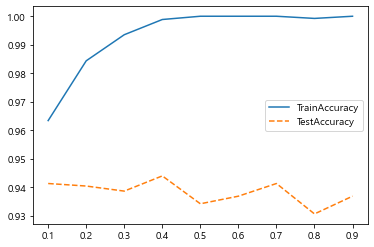

In [11]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_lr, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* learning_rate 증가하면 설명력은 증가
* 0.1 ~ 0.2 중 하나 선택

##### n_estimators : 트리 수

In [12]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# n_estimators
para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree :
    gbc = GBC(random_state = 1234,
              learning_rate = 0.1,
              n_estimators = v_n_estimators)
    gbc.fit(df_train_x, df_train_y)
    train_accuracy.append(gbc.score(df_train_x, df_train_y))
    test_accuracy.append(gbc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


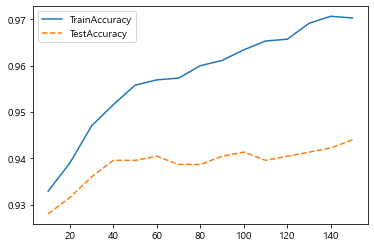

In [13]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* n_estimators 증가하면 설명력은 증가
* 60, 80, 100 중 하나 선택

##### max_depth : 최대 깊이 변경에 따른 모델

In [14]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# n_estimators
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    gbc = GBC(random_state = 1234,
              learning_rate = 0.1,
              n_estimators = 100,
              max_depth = v_max_depth)
    gbc.fit(df_train_x, df_train_y)
    train_accuracy.append(gbc.score(df_train_x, df_train_y))
    test_accuracy.append(gbc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_depth.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.940
5,6,0.998,0.950
6,7,1.000,0.947
7,8,1.000,0.948
8,9,1.000,0.948
9,10,1.000,0.947


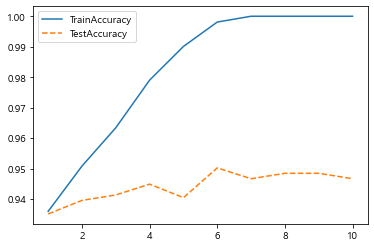

In [15]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_depth, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* max_depth 증가하면 설명력은 증가
* 4, 6 중 하나 선택

##### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델

In [16]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# min_samples_leaf
para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split :
    gbc = GBC(random_state = 1234,
              learning_rate = 0.1,
              n_estimators = 100,
              max_depth = 4,
              min_samples_split = v_min_samples_split)
    gbc.fit(df_train_x, df_train_y)
    train_accuracy.append(gbc.score(df_train_x, df_train_y))
    test_accuracy.append(gbc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.977,0.945
1,20,0.976,0.942
2,30,0.974,0.942
3,40,0.973,0.937
4,50,0.969,0.941
5,60,0.973,0.941
6,70,0.969,0.943
7,80,0.968,0.943
8,90,0.966,0.941
9,100,0.963,0.940


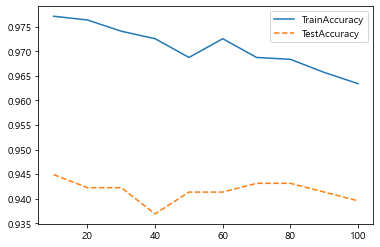

In [17]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_split, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* min_samples_split 증가하면 설명력은 감소
* 성능에 증감이 발생하고 있어 특정 값을 지정하지 않음

##### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델

In [18]:
# train/test 설명력 저장
train_accuracy = []
test_accuracy = []

# min_samples_leaf
para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf :
    gbc = GBC(random_state = 1234,
              learning_rate = 0.1,
              n_estimators = 100,
              max_depth = 4,
              min_samples_leaf = v_min_samples_leaf)
    gbc.fit(df_train_x, df_train_y)
    train_accuracy.append(gbc.score(df_train_x, df_train_y))
    test_accuracy.append(gbc.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

# 모델 설명력 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.977,0.946
1,20,0.970,0.942
2,30,0.970,0.942
3,40,0.963,0.940
4,50,0.960,0.942
5,60,0.958,0.939
6,70,0.958,0.937
7,80,0.955,0.940
8,90,0.950,0.936
9,100,0.948,0.938


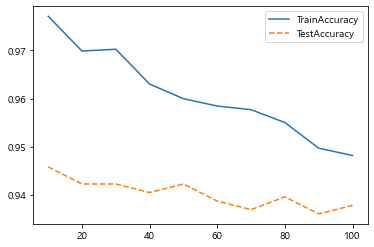

In [19]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'TrainAccuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = 'TestAccuracy')
plt.legend()

* min_samples_leaf 증가하면 설명력은 감소
* 10, 20 중 하나 선택

##### GridSearchCV

In [20]:
estimator = GBC(n_estimators = 100, random_state = 1234)
# parameter
para_grid = {'learning_rate' : para_lr,
             'max_depth' : para_depth,
             'min_samples_leaf' : para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_gbc = GridSearchCV(estimator,
                        para_grid,
                        scoring = 'accuracy',
                        n_jobs = -1)
grid_gbc.fit(df_train_x, df_train_y)
# 결과 확인
print('best estimator model: \n{}'.format(grid_gbc.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_gbc.best_params_))
print('\nbest score: \n{}'.format(grid_gbc.best_score_.round(4)))

best estimator model: 
GradientBoostingClassifier(learning_rate=0.6000000000000001, max_depth=10,
                           min_samples_leaf=10, random_state=1234)

best parameter: 
{'learning_rate': 0.6000000000000001, 'max_depth': 10, 'min_samples_leaf': 10}

best score: 
0.9565


# Step 3. 최종 모델 선정

### 최종 모델 생성

In [21]:
# 최종 모델
gbc_final = GBC(random_state = 1234,
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 4,
                min_samples_leaf = 10)
gbc_final.fit(df_train_x, df_train_y)
# train/test 데이터 설명력
print('Score in train set :', gbc_final.score(df_train_x, df_train_y).round(4))
print('Score in test set :', gbc_final.score(df_test_x, df_test_y).round(4))

Score in train set : 0.9771
Score in test set : 0.9458


### 최종 모델 평가

In [22]:
# 평가
y_pred = gbc_final.predict(df_test_x)
print('Accuracy : {0:.3f}\n'.format(gbc_final.score(df_test_x,df_test_y)))
print('Confusion matrix :\n{}'.format(confusion_matrix(df_test_y, y_pred)))
# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits = 3))

Accuracy : 0.946

Confusion matrix :
[[1018    3]
 [  58   46]]
              precision    recall  f1-score   support

           0      0.946     0.997     0.971      1021
           1      0.939     0.442     0.601       104

    accuracy                          0.946      1125
   macro avg      0.942     0.720     0.786      1125
weighted avg      0.945     0.946     0.937      1125



# Step 4. 결론 도출

### 설명변수 중요도

In [23]:
# 변수명 저장
v_feature_name = df_train_x.columns
# 설명변수 중요도 확인 및 테이블 형태 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gbc_final.feature_importances_
# 중요도별 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.327
6,CLAGE,0.120
2,VALUE,0.107
8,CLNO,0.105
5,DELINQ,0.100
0,LOAN,0.072
1,MORTDUE,0.041
7,NINQ,0.038
4,DEROG,0.034
3,YOJ,0.033


### 설명변수 중요도 그래프

Text(0, 0.5, '변수')

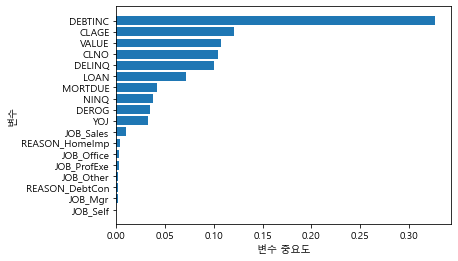

In [24]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

* DEBTINC, CLAGE, VALUE 순으로 영향이 크다고 볼 수 있다.
* 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다.